# silico general demo

## Introduction

In [1]:
import pandas as pd
import numpy as np
from numpy import random

In [2]:
import silico

Define a function that takes some parameters and returns a dict of information about the results:

In [3]:
def experiment_f(mean, sigma, seed):
    # All seeds should be initialized using a parameter for reproducibility
    random.seed(seed)
    # Return a dict with the results (must be pickleable)
    return {"value": random.normal(mean, sigma)}

Define the values for each of the parameters:

In [4]:
experiment = silico.Experiment(
    [
        ("mean", [1, 2, 4]),
        ("sigma", [1, 2, 3]),
        ("seed", list(range(20))),
    ],
    experiment_f,  # Function
    "experiment-demo",  # Folder where the results are stored
)

In [5]:
# If the definition of the experiment has changed, previous results can be deleted by running:
experiment.invalidate()

In [6]:
experiment.run_all()

  0%|          | 0/180 [00:00<?, ?it/s]

To obtain a table with results:

In [7]:
df=experiment.get_results_df()
df

_run_start  _elapsed_seconds     value
mean sigma seed                                                        
1    1     0     2023-03-23 01:20:53.154519          0.000054  2.764052
           1     2023-03-23 01:20:53.155430          0.000050  2.624345
           2     2023-03-23 01:20:53.156125          0.000030  0.583242
           3     2023-03-23 01:20:53.156363          0.000023  2.788628
           4     2023-03-23 01:20:53.156568          0.000021  1.050562
...                                     ...               ...       ...
4    3     15    2023-03-23 01:20:53.187919          0.000010  3.063015
           16    2023-03-23 01:20:53.188014          0.000010  4.383846
           17    2023-03-23 01:20:53.188111          0.000009  4.828798
           18    2023-03-23 01:20:53.188217          0.000010  4.238285
           19    2023-03-23 01:20:53.188313          0.000010  4.663010

[180 rows x 3 columns]

## Plot and table generation

Some examples for figure and table generation follow

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

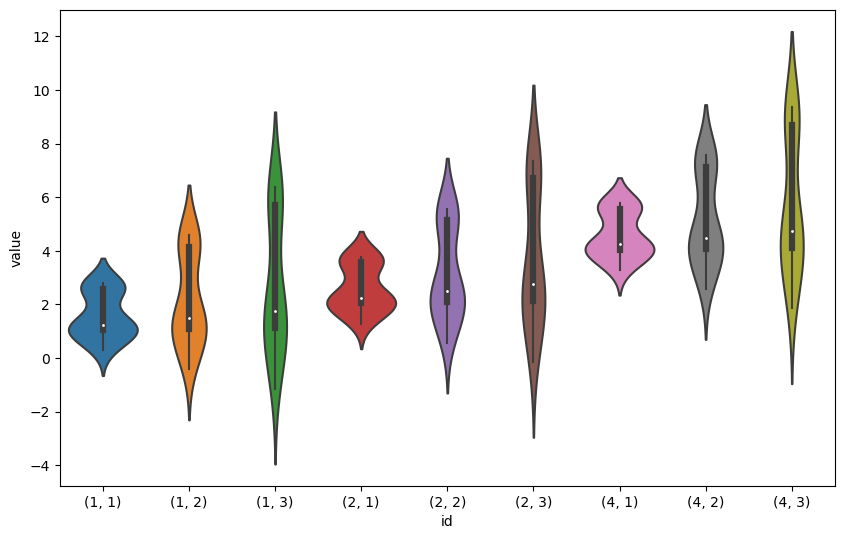

In [9]:
# Add an id field concatenating the two relevant levels of the index:
df["id"]=df.reset_index(["mean", "sigma"]).apply(lambda x: "(%s, %s)"%(x["mean"],x["sigma"]), axis=1).values

plt.figure(figsize=(10, 10 / 1.618))
sns.violinplot(
    data=df,
    x="id",
    y="value",
)
# plt.ylim(0.8, 1.1)
plt.show()

In [10]:
# Produce a table summarizing the mean values with its error
silico.df_agg_mean(df.drop(["_run_start", "id"], axis=1), ["mean", "sigma"])

_elapsed_seconds        value
mean sigma                                      
1    1          0.000023 ± 0.000002  1.58 ± 0.19
     2        0.0000262 ± 0.0000014    2.2 ± 0.4
     3        0.0000219 ± 0.0000009    2.7 ± 0.6
2    1          0.000028 ± 0.000002  2.58 ± 0.19
     2        0.0000243 ± 0.0000014    3.2 ± 0.4
     3          0.000024 ± 0.000003    3.7 ± 0.6
4    1        0.0000156 ± 0.0000005  4.58 ± 0.19
     2      0.00000995 ± 0.00000009    5.2 ± 0.4
     3      0.00000975 ± 0.00000010    5.7 ± 0.6

## Modifying task iteration order

**Evaluation order is only important if you interfere with the run before it finishes** (e.g, looking at intermediate results) **or if you want to explore only a subset of the parameter space**.

The default strategy follows an ordered array from inner to outer coordinates. The experiment definition could be manipulated to alter this, modifying the variable order or the values list.

In [11]:
# Check the chronological execution order in the previous example
df.sort_values("_run_start").index

MultiIndex([(1, 1,  0),
            (1, 1,  1),
            (1, 1,  2),
            (1, 1,  3),
            (1, 1,  4),
            (1, 1,  5),
            (1, 1,  6),
            (1, 1,  7),
            (1, 1,  8),
            (1, 1,  9),
            ...
            (4, 3, 10),
            (4, 3, 11),
            (4, 3, 12),
            (4, 3, 13),
            (4, 3, 14),
            (4, 3, 15),
            (4, 3, 16),
            (4, 3, 17),
            (4, 3, 18),
            (4, 3, 19)],
           names=['mean', 'sigma', 'seed'], length=180)

An alternative strategy can be used to explore the same grid in a different order by first picking the corners and the choosing always a point furthest away from already picked ones. This is called the *urinal* strategy, since this implements [a protocol known by most men](https://blog.xkcd.com/2009/09/02/urinal-protocol-vulnerability/).

In [12]:
experiment_urinal = silico.Experiment(
    [
        ("mean", [1, 2, 4]),
        ("sigma", [1, 2, 3]),
        ("seed", list(range(20))),
    ],
    experiment_f,  # Function
    "experiment-demo-urinal",  # Folder where the results are stored
    strategy="urinal"
)

In [13]:
experiment_urinal.invalidate()
experiment_urinal.run_all()

  0%|          | 0/180 [00:00<?, ?it/s]

In [14]:
# Now corners are first explored
experiment_urinal.get_results_df().sort_values("_run_start").index

MultiIndex([(1, 1,  0),
            (1, 1, 19),
            (1, 3,  0),
            (1, 3, 19),
            (4, 1,  0),
            (4, 1, 19),
            (4, 3,  0),
            (4, 3, 19),
            (2, 2,  9),
            (1, 1, 13),
            ...
            (4, 3,  5),
            (4, 3,  7),
            (4, 3,  8),
            (4, 3, 10),
            (4, 3, 11),
            (4, 3, 13),
            (4, 3, 14),
            (4, 3, 16),
            (4, 3, 17),
            (4, 3, 18)],
           names=['mean', 'sigma', 'seed'], length=180)

Finally, if you are interested on fixing a point and studying variations of only one variable, you might be interested in the *star* strategy, which first studies a special mid_point argument (default to the median for numerical data) and then explores each of the 1d subspaces.

In [15]:
experiment_star = silico.Experiment(
    [
        ("mean", [1, 2, 4]),
        ("sigma", [1, 2, 3]),
        ("seed", list(range(20))),
    ],
    experiment_f,
    "experiment-demo-star", 
    strategy="star",
    mid_point={"mean":2,"sigma":2,"seed":10} # Default to the median for numerical data
)

In [16]:
experiment_star.invalidate()
experiment_star.run_all()

  0%|          | 0/24 [00:00<?, ?it/s]

In [17]:
# Very few points (~sum of dims instead of product of dims)
experiment_star.get_results_df().sort_values("_run_start").index

MultiIndex([(2, 2, 10),
            (1, 2, 10),
            (4, 2, 10),
            (2, 1, 10),
            (2, 3, 10),
            (2, 2,  0),
            (2, 2,  1),
            (2, 2,  2),
            (2, 2,  3),
            (2, 2,  4),
            (2, 2,  5),
            (2, 2,  6),
            (2, 2,  7),
            (2, 2,  8),
            (2, 2,  9),
            (2, 2, 11),
            (2, 2, 12),
            (2, 2, 13),
            (2, 2, 14),
            (2, 2, 15),
            (2, 2, 16),
            (2, 2, 17),
            (2, 2, 18),
            (2, 2, 19)],
           names=['mean', 'sigma', 'seed'])

You can also run sequentially multiple Experiment instances with the same function in the same folder to achieve other strategies.

A SubExperiment class is also available to restrict some of the parameters.

In [18]:
list(silico.SubExperiment(experiment, {"mean":3, "seed":5}).iter_values())

[{'sigma': 1}, {'sigma': 2}, {'sigma': 3}]

## Loading from a module and execution modes

The best practice is to define the experiment in a module

In [19]:
import demo

In this example we include a delay in the function to understand the execution modes

In [20]:
# Check for demo purpose
import inspect
print(inspect.getsource(demo.experiment.f))

def experiment_f(mean, sigma, seed):
    # All seeds should be initialized using a parameter for reproducibility
    random.seed(seed)
    # Delay for test purpose
    sleep(mean/100)
    # Return a dict with the results (must be pickleable)
    return {"value": random.normal(mean, sigma)}



### Sequential execution

The default mode is sequential execution (all trials are executed one by one).

Advantages:

- All memory/cpu resources available 
- Execution time is not affected by other processes

Disadvantages:

- Longest execution time

In [21]:
demo.experiment.invalidate()

In [22]:
%%time
demo.experiment.run_all()

  0%|          | 0/180 [00:00<?, ?it/s]

CPU times: user 210 ms, sys: 30.6 ms, total: 240 ms
Wall time: 4.42 s


In [23]:
sum(demo.experiment.get_results_df()["_elapsed_seconds"])

4.246137000000002

### Multithreading execution 

In multithreading execution a pool of threads run the trials.

Advantages:

- If n threads are used and the trial uses only one thread, you can expect a factor of n speed-up, assumming your resources are not exhausted.
- Does not require additional libraries.

Disadvantages:

- Memory consumption increases
- Concurrent execution might affect computation time
- Only one machine can be used still.

In [24]:
demo.experiment.invalidate()

In this example we use 4 threads for a ~4x speed-up:

In [25]:
%%time
demo.experiment.run_all(method="multithreading", threads=4)

  0%|          | 0/180 [00:00<?, ?it/s]

CPU times: user 73.2 ms, sys: 60.1 ms, total: 133 ms
Wall time: 1.17 s


However, elapsed time is independent for each trial, so the total is approximately the same

In [26]:
sum(demo.experiment.get_results_df()["_elapsed_seconds"])

4.24141